In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [92]:
# Replace this path with the path to your 'images' directory
base_dir = 'images'

In [93]:
def load_data(dataset_path, img_size=(128, 128)):
    data = []
    labels = []
    for fruit_dir in os.listdir(dataset_path):
        fruit_label = fruit_dir
        fruit_path = os.path.join(dataset_path, fruit_dir)
        for img_name in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, img_size)
            data.append(img_resized)
            labels.append(fruit_label)
    return data, labels


In [94]:
data, labels = load_data(base_dir)
data = np.array(data)
labels = pd.Series(labels, name='Fruit')

# Question 1: Distribution of images among fruit classes

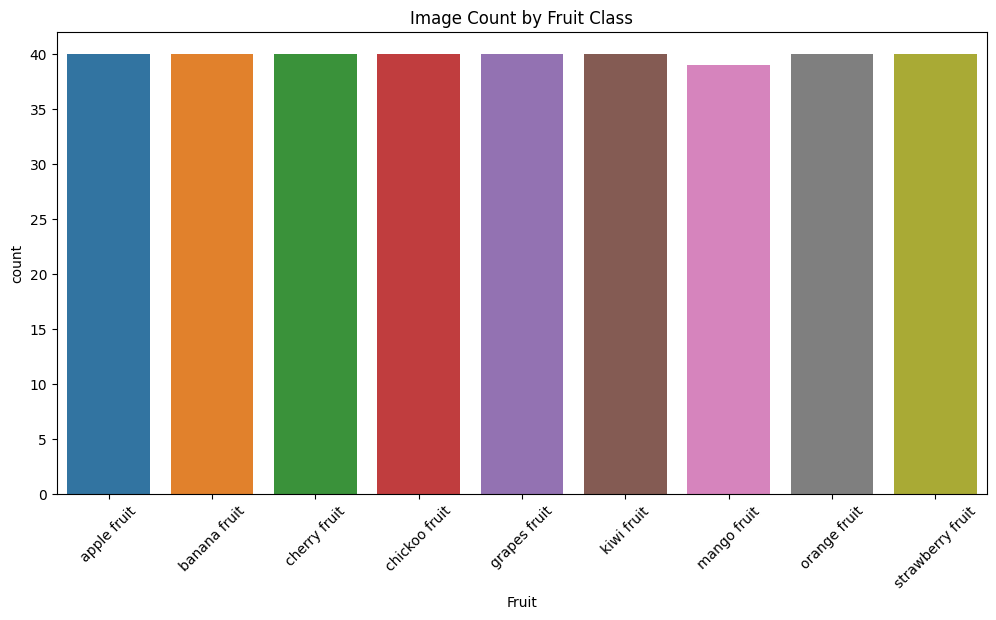

In [95]:
plt.figure(figsize=(12, 6))
labels = pd.DataFrame(labels, columns=['Fruit'])
sns.countplot(data=labels, x='Fruit')
plt.xticks(rotation=45)
plt.title('Image Count by Fruit Class')
plt.show()

# Question 2: Average size of images

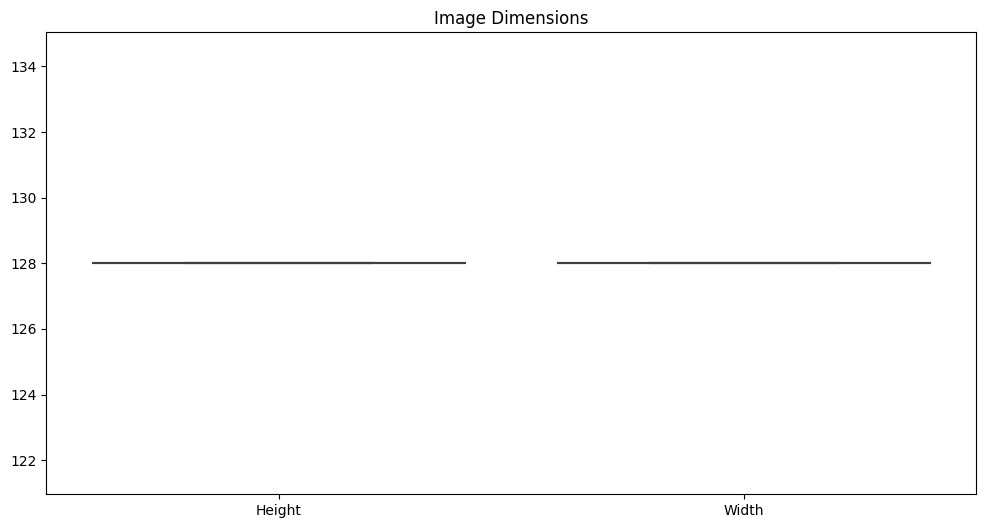

In [96]:
heights = [img.shape[0] for img in data]
widths = [img.shape[1] for img in data]

plt.figure(figsize=(12, 6))
sns.boxplot(data=[heights, widths])
plt.xticks(ticks=[0, 1], labels=['Height', 'Width'])
plt.title('Image Dimensions')
plt.show()

# Question 3: Correlation between color channels

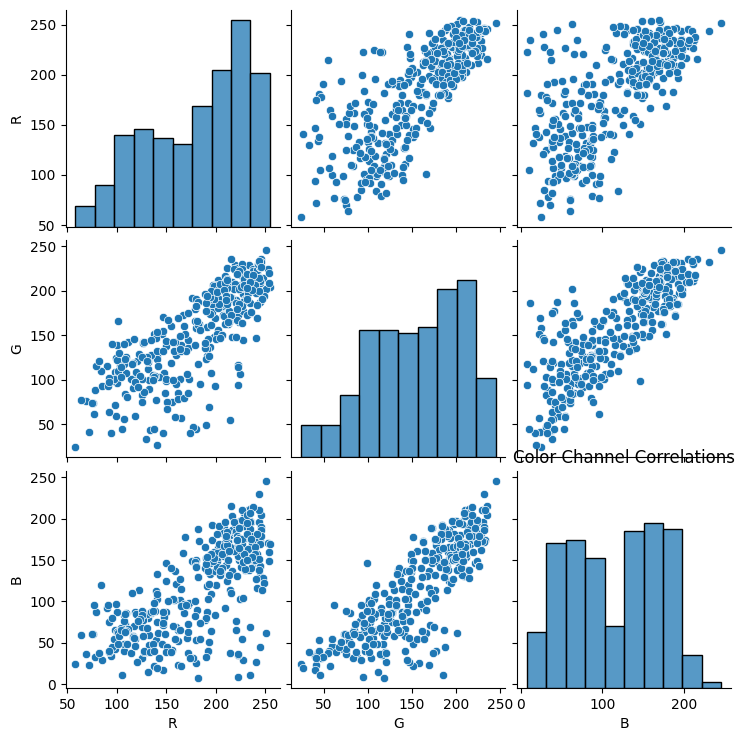

In [97]:
def avg_color_channels(img):
    return np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])

avg_colors = np.array([avg_color_channels(img) for img in data])
avg_colors_df = pd.DataFrame(avg_colors, columns=['R', 'G', 'B'])

sns.pairplot(avg_colors_df)
plt.title('Color Channel Correlations')
plt.show()

# Question 4: Pixel intensity distributions

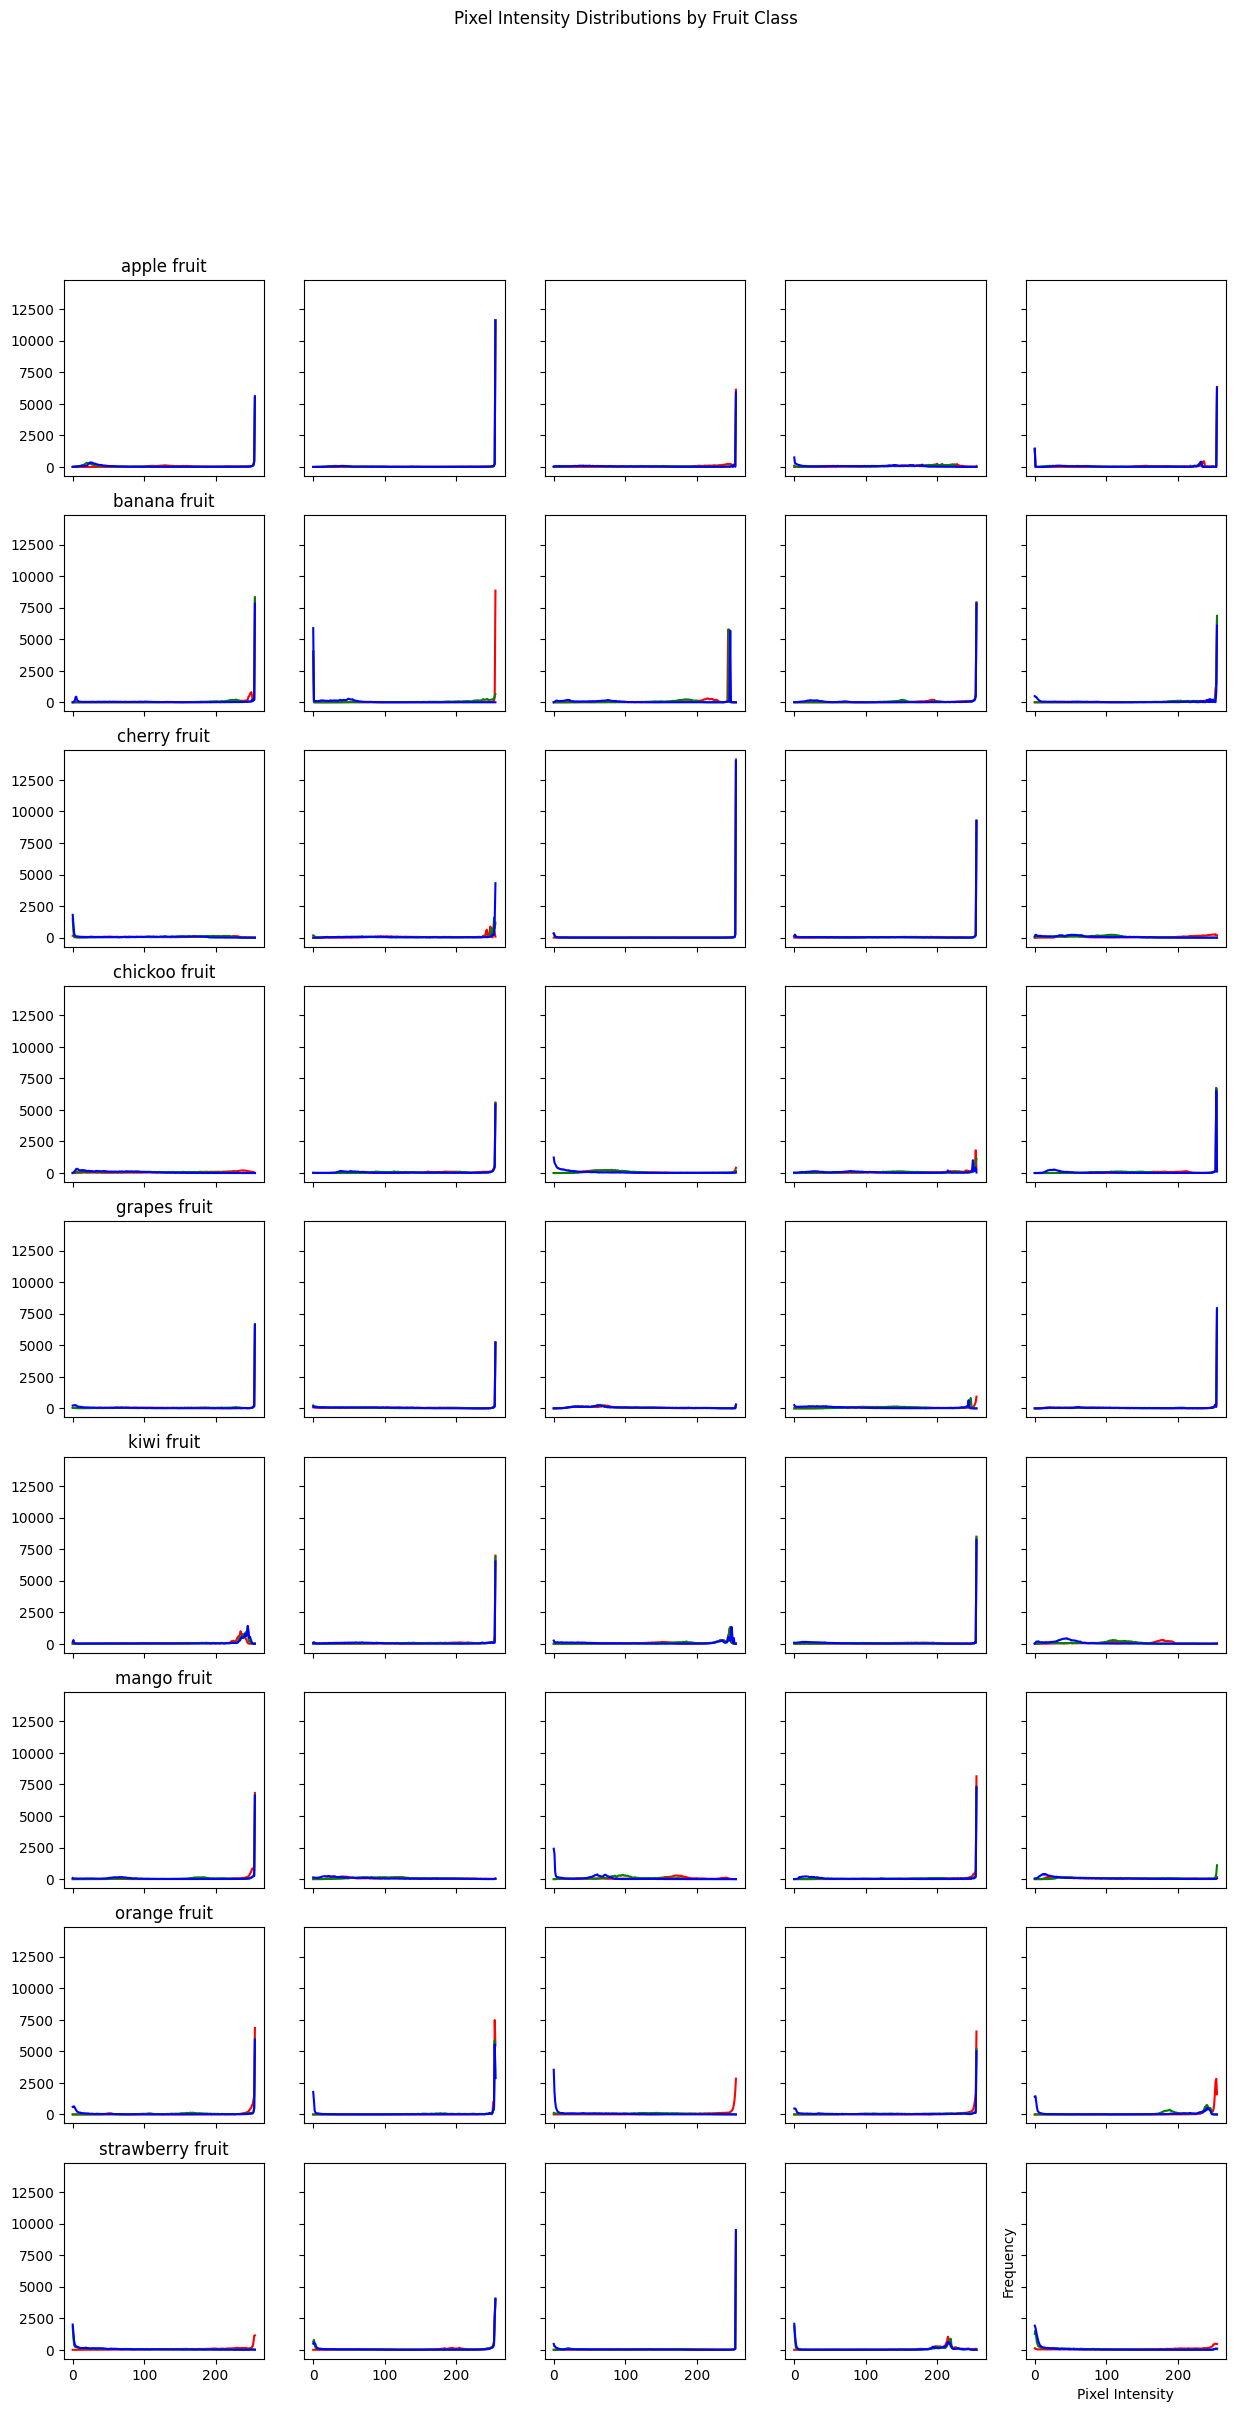

In [98]:
def plot_intensity_histogram(img, ax, label):
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        ax.plot(hist, color=color)
    ax.set_title(label)

n_examples = 5
fruit_classes = labels['Fruit'].unique()
n_classes = len(fruit_classes)

fig, axes = plt.subplots(nrows=n_classes, ncols=n_examples, figsize=(15, 3*n_classes), sharex=True, sharey=True)
for i, fruit_class in enumerate(fruit_classes):
    example_imgs = data[labels['Fruit'] == fruit_class][:n_examples]
    for j, img in enumerate(example_imgs):
        plot_intensity_histogram(img, axes[i, j], fruit_class if j == 0 else '')

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.suptitle('Pixel Intensity Distributions by Fruit Class')
plt.show()


# Question 5: t-SNE visualization

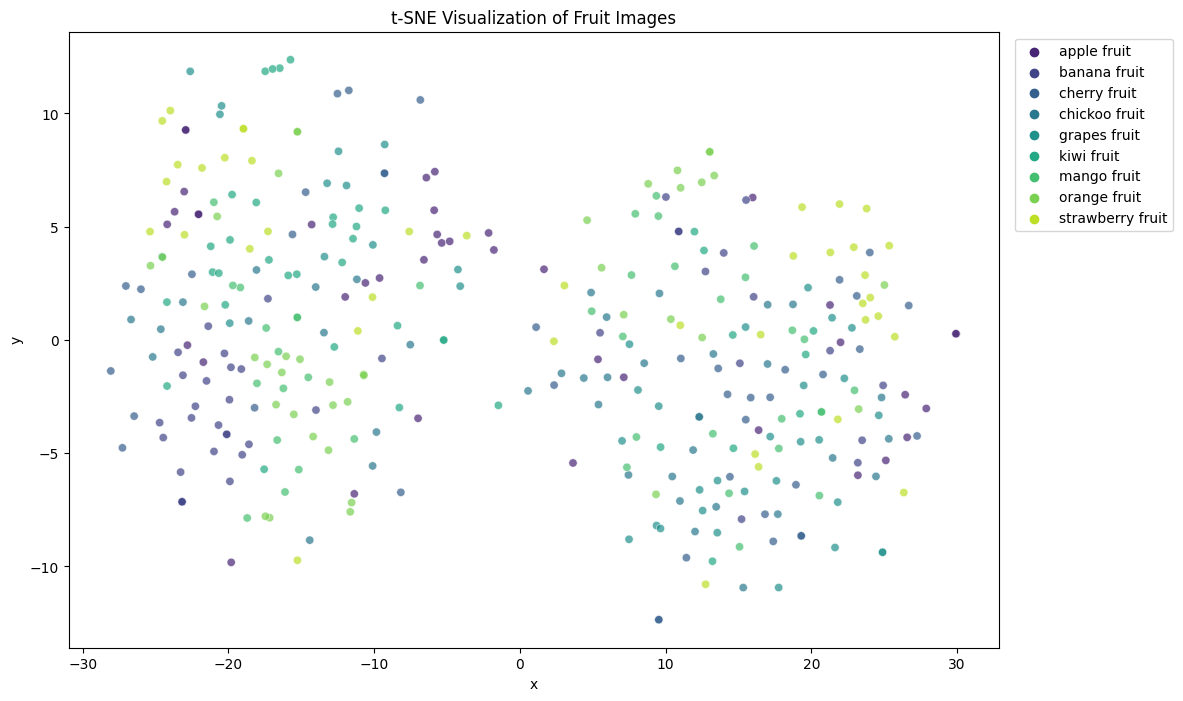

In [99]:
# Flatten and normalize images
data_flat = np.array([img.flatten() for img in data])
data_flat = data_flat / 255.0

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(data_flat)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(data_2d, columns=['x', 'y'])
tsne_df['label'] = labels['Fruit']

# Plot t-SNE results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='label', palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Fruit Images')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

# Model Implementation

In [100]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)


In [101]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify that this is the training set
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify that this is the validation set
)


Found 288 images belonging to 9 classes.
Found 71 images belonging to 9 classes.


In [104]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices),activation='softmax')
    
    
])
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])


In [85]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Set the number of output nodes based on the number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [105]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

Epoch 1/50
9/9 [==============================] - 10s 968ms/step - loss: 2.3495 - accuracy: 0.0903 - val_loss: 2.1664 - val_accuracy: 0.1127
Epoch 2/50
9/9 [==============================] - 8s 898ms/step - loss: 2.1411 - accuracy: 0.1493 - val_loss: 2.0191 - val_accuracy: 0.2958
Epoch 3/50
9/9 [==============================] - 9s 933ms/step - loss: 1.9200 - accuracy: 0.2188 - val_loss: 1.8170 - val_accuracy: 0.2958
Epoch 4/50
9/9 [==============================] - 8s 882ms/step - loss: 1.8095 - accuracy: 0.2396 - val_loss: 1.7169 - val_accuracy: 0.3099
Epoch 5/50
9/9 [==============================] - 8s 875ms/step - loss: 1.7027 - accuracy: 0.2951 - val_loss: 1.7276 - val_accuracy: 0.2535
Epoch 6/50
9/9 [==============================] - 8s 907ms/step - loss: 1.5733 - accuracy: 0.3750 - val_loss: 1.5665 - val_accuracy: 0.3803
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 1.4834 - accuracy: 0.3993 - val_loss: 1.3750 - val_accuracy: 0.5070
Epoch 8/50
9/9 [======

In [106]:
model.save("model.h5")

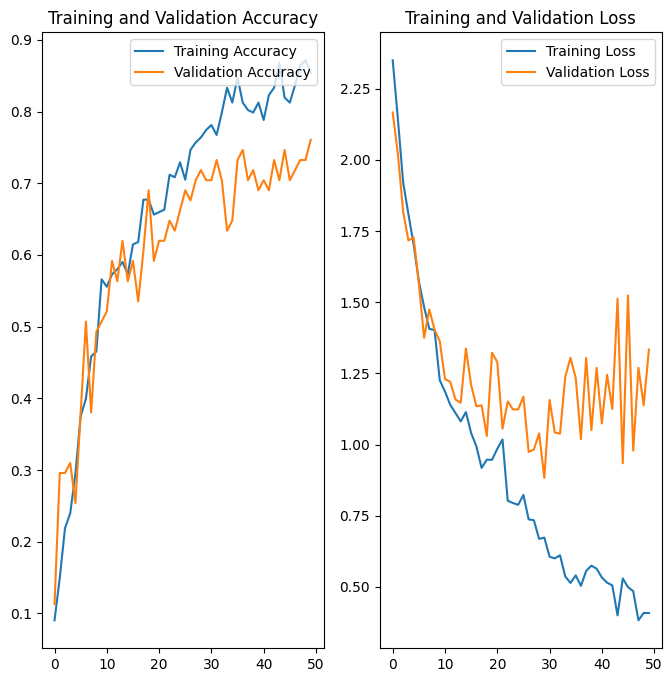

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()